In [2]:
from tkinter import ttk #8.5で採用された現代的なテーマ
import tkinter as tk
from tkinter import messagebox #メッセージボックスを出す
from tkinter import filedialog
import subprocess, configparser, time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from PIL import ImageTk
import csv, re, xlrd, openpyxl, sys, random, os
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse import spdiags
import scipy.sparse.linalg as spla
from scipy.signal import find_peaks
import glob

def open_data(path):
    with open(path,encoding='UTF-16') as f:
        next(f)
        col = next(f)[:-1].split(",")
        df = np.empty((0, len(col)))
        for line in f:
            if line =="\n":
                break
            df1 = [float(i) for i in line[:-1].split(",")]
            df = np.vstack((df, df1))
        df = pd.DataFrame(df, columns=col)
    return df
def all_data_path(path):
    all_file=[] #ファイルインデックス
    all_name=[]
    for file in sorted(os.listdir(path)):
        name,ext = os.path.splitext(file)
        if ext == ".xl":
            all_file.append(path+"/"+file)
            all_name.append(name)
    return all_file,all_name

def folder2list(pathes):
    aldata=[]
    for b in pathes:
        df1 = open_data(b)
        aldata.append(df1)
    return aldata

def baseline_als(y, lam, p, niter=100):
    #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
    #p: 0.001 - 0.1, lam: 10^2 - 10^9
    # Baseline correction with asymmetric least squares smoothing, P. Eilers, 2005
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spla.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def sekibun(y, new_spliter, times):
    value=[]
    for s in new_spliter[:-1]:
        y_sum = y[s : s+times].sum()
        value.append(y_sum)
    return value

def estimate_range(x,y,koutei = False, height = 18000, margin = 20, tilt=500, paramAsLS = [100, 0.6]):
    b = baseline_als(y,paramAsLS[0],paramAsLS[1])
    peaks, _ = find_peaks(y,distance=1,height=height)
    f = y.values[peaks] > b[peaks]
    maxpeaks=np.hstack((np.array([0]),peaks[f]))
    for i in range(1,len(maxpeaks)-1):
        if maxpeaks[i+1] - maxpeaks[i] < margin:
            maxpeaks[i+1] = maxpeaks[i]
    maxpeaks = np.unique(maxpeaks)
    g=np.empty(0)
    for i,_ in enumerate(y[1:]):
        d = y.values[i] - y.values[i-1]
        g=np.append(g,d)
    a=[]
    spliter=[]
    for i in range(len(maxpeaks)-1):
        a=[]
        sp=0
        for j in range(maxpeaks[i],maxpeaks[i+1]):
            if g[j] < tilt:
                sp = j
        spliter.append(sp)
    spliter = np.unique(spliter)
    new_spliter1 = new_spliter_search(x,y,spliter)
    return new_spliter1, spliter , b, maxpeaks

def new_spliter_search(x,y,spliter):
    delta = np.empty(0,dtype=int)
    for i,_ in enumerate(spliter[:-1]):
        delta = np.hstack((delta,int(spliter[i+1] - spliter[i])))
    unique, freq = np.unique(delta, return_counts=True)
    mode = unique[np.argmax(freq)]
    #print(unique[np.argsort(freq)[::-1]])
    #print(np.sort(freq)[::-1])
    new_spliter = spliter.tolist()
    while new_spliter[0] - mode > 0:
        new_spliter.append(new_spliter[0] - random.choices(unique[np.argsort(freq)][::-1][:2], weights = np.sort(freq)[::-1][:2])[0])
        new_spliter.sort()
    i=0
    while new_spliter[i] != new_spliter[-1]:
        aida = new_spliter[i+1] - new_spliter[i]
        if aida > 2*(mode-2):
            syou = aida
            for j in range(2, 65):
                if abs(syou - mode) > abs(aida/j - mode):
                    syou = aida / j
                else:
                    break
            for k in range(1, j-1):
                new_spliter.append(new_spliter[i] + int(syou*k))
            new_spliter.sort()
            i+=1
        else:
            i+=1
    while len(new_spliter) < 66:
        new_spliter.append(new_spliter[-1] + mode)        
    return new_spliter

def delta(s1):
    delta = np.empty(0)
    for i in range(len(s1)-1):
        delta = np.append(delta, s1[i+1]-s1[i])
    unique, freq = np.unique(delta, return_counts=True)
    text = ""
    for i in range(len(unique)):
        text = text + str(int(unique[i])) + ": " + str(freq[i]) + "回，  "
    return text

In [ ]:
from matplotlib.figure import Figure
root = tk.Tk()
myfont=("MSゴシック", "10")
wb1 = openpyxl.Workbook()
ws1 = wb1.active
ws1.cell(row = 1, column = 1, value = "x軸")
ws1.cell(row = 1, column = 2, value = "y軸")
wb2 = openpyxl.Workbook()
ws2 = wb2.active
class Edit:
    def __init__(self,root):
        self.root = root

        self.frame = tk.Frame(root)
        self.frame.pack(side = tk.TOP)

        label1 = tk.Label(self.frame, text=" ピーク高さ", font=("MSゴシック", "14"))
        label1.pack(side = tk.LEFT)
        self.peak = tk.Entry(self.frame, width=6)
        self.peak.insert(tk.END, "550")
        self.peak.pack(side = tk.LEFT)
        
        label2 = tk.Label(self.frame, text=" 傾き", font=("MSゴシック", "14"))
        label2.pack(side = tk.LEFT)        
        self.tilt = tk.Entry(self.frame, width=6)
        self.tilt.insert(tk.END, "50")
        self.tilt.pack(side = tk.LEFT)
        
        label3 = tk.Label(self.frame, text=" 計算範囲", font=("MSゴシック", "14"))
        label3.pack(side = tk.LEFT)
        self.area = tk.Entry(self.frame, width=6)
        self.area.insert(tk.END, "8")
        self.area.pack(side = tk.LEFT)
        
        self.listbox = tk.Listbox(root)
        yScrolBar = tk.Scrollbar(self.listbox, orient=tk.VERTICAL)
        yScrolBar.pack(side=tk.RIGHT,fill="y") #textのみぎｙ軸FILL
        xScrolBar = tk.Scrollbar(self.listbox, orient=tk.HORIZONTAL)
        xScrolBar.pack(side=tk.BOTTOM,fill="y") #textのみぎｙ軸FILL
        self.listbox['yscrollcommand'] = yScrolBar.set
        self.listbox['xscrollcommand'] = xScrolBar.set
        xScrolBar.config(command=self.listbox.xview)
        yScrolBar.config(command=self.listbox.yview)
        self.listbox.pack(side=tk.LEFT, fill="y")
        self.listbox.bind("<<ListboxSelect>>", self.click)
        
        self.state = tk.Frame(root)
        self.state.pack(side = tk.BOTTOM)
        self.text = tk.StringVar()
        self.text.set("Test")
        auto = tk.Button(self.state, text="AUTO", command = self.auto_split)
        auto.pack(side = tk.RIGHT)
        state_label = tk.Label(self.state, textvariable=self.text, font=("MSゴシック", "14"))
        state_label.pack(side = tk.RIGHT)
        
        fig = Figure(figsize=(16, 9), dpi=80)
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
        self.ax = fig.add_subplot(1, 1, 1)
        self.ax.set_xlabel("loc", size = 16, weight = "light")
        self.ax.set_ylabel("Intensity", size = 16, weight = "light")
        self.ax.tick_params(labelsize=16)
        self.fig_canvas = FigureCanvasTkAgg(fig, self.root)
        toolbar = NavigationToolbar2Tk(self.fig_canvas, self.root)
        self.fig_canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        self.cul = 4
        self.tar_cul = 4
        self.fileTypes=[
            ("テキストファイル",'*.txt'),
            ("すべてのファイル",'*.*')
        ]
        self.directory = "."
        
        root.title(self.__class__.__name__)#クラスネーム参照
        
        clientHeight = "720"
        clientWidth = "1280"
        cp = configparser.ConfigParser()# ini読み込み準備
        try:
            cp.read(self.__class__.__name__+".ini")
            clientHeight = cp["Client"]["Height"]
            clientWidth = cp["Client"]["Width"]
            self.directory = cp["File"]["Directory"]
        except:
            print(self.__class__.__name__+" :Use default value",file=sys.stderr)

        root.geometry(clientWidth+"x"+clientHeight)
        #root.protocol("WM_DELETE_WINDOW",self.menuFileExit) #右上の×終了でもイベントに飛ばす。
        self.create_menu()

    def create_menu(self):
        menu = tk.Menu(tearoff=0) #インスタンスフォルダ名に使う
        menu_File = tk.Menu(tearoff=0) #インスタンスファイル名に使う
        menu_Help = tk.Menu(tearoff=0)
        
        menu.add_cascade(menu=menu_File, label="ファイル(F)", underline=5,font=myfont)#フォルダ作成。5番目にAlt押すとアンダーラインかつアクセスキー
        menu_File.add_command(label="開く(O)",underline=3,command = self.menuFileOpen,font=myfont)#ファイル作成
        menu_File.add_command(label="終了(X)",underline=3,command = self.menuFileExit,font=myfont)#終了ファイル作成
        
        menu.add_cascade(menu=menu_Help, label="ヘルプ(H)", underline=4,font=myfont)
        menu_Help.add_command(label="ヘルプ(W)", underline=4, command = self.menuHelpOpen,font=myfont)
        menu_Help.add_separator()
        menu_Help.add_command(label="バージョン確認(V)",underline=8, command = self.menuHelpVersion,font=myfont)
        root["menu"] = menu

    def menuFileOpen(self):
        self.directname = filedialog.askdirectory(initialdir = self.directory)
        if not self.directname: #無きゃ中止
            return

        self.path, file_name = all_data_path(self.directname)
        if self.path == []:
            massagebox.showwarning(self.__class__.__name__,"ファイルがありません。")
        else:
            self.listbox.insert(tk.END, *file_name)
            self.aldf = folder2list(self.path)
            self.columns = self.aldf[0].columns.tolist()
            self.combobox = ttk.Combobox(self.frame, width=8, values = self.columns[1:], state="readonly")
            self.combobox.set(self.columns[1])
            self.combobox.bind('<<ComboboxSelected>>', self.combochange)
            self.combobox.pack(side = tk.RIGHT)
            label1 = tk.Label(self.frame, text=" ターゲット選択", font=("MSゴシック", "14"))
            label1.pack(side = tk.LEFT)
            self.combobox1 = ttk.Combobox(self.frame, width=8, values = self.columns[1:], state="readonly")
            self.combobox1.set(self.columns[4])
            self.combobox1.bind('<<ComboboxSelected>>', self.combochange)
            self.combobox1.pack(side = tk.LEFT)
            tk.Label(self.frame, text=" ", font=("MSゴシック", "14")).pack(side = tk.LEFT)
            tk.Label(self.frame, text=" ", font=("MSゴシック", "14")).pack(side = tk.RIGHT)
            self.save = tk.Button(self.frame, text="Excel保存", command = self.save2excel)
            self.save.pack(side = tk.RIGHT)
            '''
            self.save = tk.Button(self.frame, text="比率", command = self.sub_window)
            self.save.pack(side = tk.RIGHT)
            '''
            for i in range(len(self.columns)-1):
                ws1.cell(row = 1, column = i + 3, value = self.columns[i+1])
            self.data = np.zeros((self.aldf[0].shape[1], len(self.aldf), 65))
    def menuHelpOpen(self):
        subprocess.Popen(["start","readme.txt"],shell=True)

    def menuFileExit(self):
        cp = configparser.ConfigParser()
        cp["Client"] = {
            "Height": str(root.winfo_height()),
            "Width": str(root.winfo_width())
        }
        cp["File"] = {"Directory": self.directory}
        with open(self.__class__.__name__+".ini","w") as f:
            cp.write(f)
        root.destroy()
    def menuHelpVersion(self):
        s= self.__class__.__name__
        s+=" Version 0.01(2023/3/02)\n"
        s+="©2023 HIROMI YOKOTA\n"
        s+="with Python "+sys.version
        messagebox.showinfo(self.__class__.__name__, s)
        
    def auto_split(self):
        s1 = np.linspace(0, self.aldf[self.indices].shape[0]-1, 66+2,dtype = int)[1:-1]
        for j in range(self.aldf[0].shape[1]):
            self.data[j][self.indices] = sekibun(self.aldf[self.indices].iloc[:,j], new_spliter = s1, times = int(self.area.get()))
        text = "auto"
        self.text.set(text)
        for i in range(1,len(self.columns)):
            values = sekibun(self.aldf[self.indices].iloc[:,i], s1, times = int(self.area.get()))
            for j in range(len(values)):
                ws1.cell(row = self.indices * 65 + j + 2, column = i + 2, value = values[j])
                ws2.cell(row = (len(self.aldf)+1) * (i-1) + self.indices+1, column = j+1, value = values[j])
        self.ax.plot(self.aldf[self.indices].iloc[:,0].values[s1],self.aldf[self.indices][self.combobox.get()].values[s1],"o")
        self.fig_canvas.draw()
        
    def combochange(self, event):  
        self.ax.cla()
        self.ax.plot(self.aldf[self.indices].iloc[:,0], self.aldf[self.indices][self.combobox.get()], lw = 2)
        self.fig_canvas.draw()
        s1, s2, b, peaks = estimate_range(self.aldf[self.indices].iloc[:,0], self.aldf[self.indices][self.combobox1.get()], height=float(self.peak.get()), tilt=float(self.tilt.get()), paramAsLS = [100, 0.6], margin=24)
        for j in range(self.aldf[0].shape[1]):
            self.data[j][self.indices] = sekibun(self.aldf[self.indices].iloc[:,j], new_spliter = s1, times = int(self.area.get()))
        text = delta(s1)
        self.text.set(text)
        for i in range(1,len(self.columns)):
            values = sekibun(self.aldf[self.indices].iloc[:,i], s1, times = int(self.area.get()))
            for j in range(len(values)):
                ws1.cell(row = self.indices * 65 + j + 2, column = i + 2, value = values[j])
                ws2.cell(row = (len(self.aldf)+1) * (i-1) + self.indices+1, column = j+1, value = values[j])
        self.ax.plot(self.aldf[self.indices].iloc[:,0].values[s1],self.aldf[self.indices][self.combobox.get()].values[s1],"o")
        self.ax.plot(self.aldf[self.indices].iloc[:,0].values[peaks],self.aldf[self.indices][self.combobox.get()].values[peaks],"x")
        self.fig_canvas.draw()
    
    def click(self, event):
        if len(self.listbox.curselection()) == 1:
            self.indices = self.listbox.curselection()[0]
            self.ax.cla()
            self.ax.plot(self.aldf[self.indices].iloc[:,0], self.aldf[self.indices][self.combobox.get()], lw = 2)
            self.fig_canvas.draw()
            s1, s2, b, peaks = estimate_range(self.aldf[self.indices].iloc[:,0], self.aldf[self.indices][self.combobox1.get()], height=float(self.peak.get()), tilt=float(self.tilt.get()), paramAsLS = [100, 0.6], margin=24)
            for j in range(self.aldf[0].shape[1]):
                self.data[j][self.indices] = sekibun(self.aldf[self.indices].iloc[:,j], new_spliter = s1, times = int(self.area.get()))
            text = delta(s1)
            self.text.set(text)
            for i in range(1,len(self.columns)):
                values = sekibun(self.aldf[self.indices].iloc[:,i], s1, times = int(self.area.get()))
                for j in range(len(values)):
                    ws1.cell(row = self.indices * 65 + j + 2, column = i + 2, value = values[j])
                    ws2.cell(row = (len(self.aldf)+1) * (i-1) + self.indices+1, column = j+1, value = values[j])
            self.ax.plot(self.aldf[self.indices].iloc[:,0].values[s1],self.aldf[self.indices][self.combobox.get()].values[s1],"o")
            self.ax.plot(self.aldf[self.indices].iloc[:,0].values[peaks],self.aldf[self.indices][self.combobox.get()].values[peaks],"x")
            self.fig_canvas.draw()
    '''
    def sub_window(self):
        self.sub_root = tk.Toplevel()
        self.sub_root.title("aaaaa")
        self.graph_frame = tk.Frame(self.sub_root)
        self.graph_frame.pack(side=tk.RIGHT)
        fig1, ax1 = plt.subplots(1,1,figsize=(16,9),dpi=80)
        fig1 = plt.rcParams['image.cmap'] = 'jet'
        self.canvas1 = FigureCanvasTkAgg(fig1, self.graph_frame)
        self.canvas1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        img = ax1.imshow(self.data[self.indices])
        cbar = fig1.colorbar(img, ax=ax, orientation='vertical')
        self.canvas1.draw()
    '''
    def save2excel(self):
        name = self.directname.split("/")[-1]
        scanlog = glob.glob(name+"/*.csv")[0]
        df = pd.read_csv(scanlog, header=0,index_col=0)
        df = df[df[" Laser State"]=="On"].iloc[:,[4,5]].values
        for i, col in enumerate(df):
            ws1.cell(row = i+2, column = 1, value = col[0])
            ws1.cell(row = i+2, column = 2, value = col[1])
        wb1.save(name + "_1.xlsx")
        wb2.save(name + "_2.xlsx")  
        for i in range(len(self.columns)):
            fig, ax = plt.subplots(1,1,figsize=(16,9),dpi=80)
            plt.rcParams['image.cmap'] = 'jet'
            img = ax.imshow(self.data[i])
            cbar = fig.colorbar(img, ax=ax, orientation='vertical')
            plt.savefig("fig_" + self.columns[i] + ".png")
            
def main():
    Edit(root)
    root.mainloop()

if __name__ == '__main__':
    main()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\yokom\AppData\Local\Temp/ipykernel_22912/1454681966.py", line 206, in click
    self.ax.plot(self.aldf[self.indices].iloc[:,0].values[s1],self.aldf[self.indices][self.combobox.get()].values[s1],"o")
IndexError: index 1808 is out of bounds for axis 0 with size 1800
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\yokom\AppData\Local\Temp/ipykernel_22912/1454681966.py", line 196, in click
    s1, s2, b, peaks = estimate_range(self.aldf[self.indices].iloc[:,0], self.aldf[self.indices][self.combobox1.get()], height=float(self.peak.get()), tilt=float(self.tilt.get()), paramAsLS = [100, 0.6], margin=24)
  File "C:\Users\yokom\AppData\Local\Temp/ipykernel_22912/13

In [5]:
path, file_name = all_data_path("mouse1")

In [6]:
def all_data_path(path):
    all_file=[] #ファイルインデックス
    all_name=[]
    for file in sorted(os.listdir(path)):
        name,ext = os.path.splitext(file)
        if ext == ".xl":
            all_file.append(path+"/"+file)
            all_name.append(name)
    return all_file,all_name

def folder2list(pathes):
    aldata=[]
    for b in pathes:
        df1 = open_data(b)
        aldata.append(df1)
        #aldata.append(df2)
    return aldata

In [7]:
def open_data(path):
    with open(path,encoding='UTF-16') as f:
        next(f)
        col = next(f).split(",")
        df = np.empty((0, len(col)))
        for line in f:
            if line =="\n":
                break
            df1 = [float(i) for i in line[:-1].split(",")]
            df = np.vstack((df, df1))
        df = pd.DataFrame(df, columns=col)
    return df

In [8]:
wb = openpyxl.Workbook()

In [12]:
ws = wb.active
for idx in range(1, 4):
    ws.cell(row=1, column=idx, value=idx)
    ws.cell(row=2, column=idx, value=-idx)

In [13]:
wb.save("mouse1.xlsx")

In [11]:
df.columns.tolist()

NameError: name 'df' is not defined

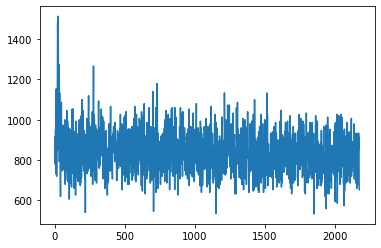

In [217]:
fig, ax = plt.subplots(1,1)
ax.plot(df.iloc[:,0], df.iloc[:,1])

In [15]:
len(np.linspace(0, 1250, 66,dtype = int))

66